In all of the machine learning projects, model selection and model evaluation are extremely important. As is known to all, learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called overfitting. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set X_test, y_test. Note that the word ‘experiment’ is not intended to denote academic use only, because even in commercial settings machine learning usually starts out experimentally. 

In this lecture, we systematically study techniques of model selection and model evaluation. We mainly follow the order of the  3rd chapter from the user guide of the 'scikit-learn' library. In the previous lectures, we have encountered these topics here and there, albeit in a non-systematic way. Here, we are summarizing some of the most important techniques and metrics so that they can be applied to many machine learning algorithms, particular those that are supervised in nature. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn import datasets
from sklearn import linear_model
from sklearn import svm

%matplotlib inline

In [2]:
os.chdir("C:\\Users\\pgao\\Documents\\PGZ Documents\\Programming Workshop\\PYTHON\\Open Courses on Python\\Udemy Course on Python\Introduction to Data Science Using Python\\datasets")

We start with our discussion on how to split data. We have seen that in 'scikit-learn' a random split into training and test sets can be quickly computed with the train_test_split() helper function. Let’s load the famous 'iris' dataset to fit a linear support vector machine on it as an example. We can quickly sample a training set while holding out 40% of the data for testing (evaluating) our classifier:

In [3]:
iris = datasets.load_iris()
print(iris.data.shape, iris.target.shape) # 4 features and 150 records
print(type(iris))
print(type(iris.data), type(iris.target))

(150, 4) (150,)
<class 'sklearn.utils.Bunch'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.4, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(90, 4) (90,)
(60, 4) (60,)


In [5]:
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train) # 'clf' stands for 'classifier' here
clf.score(X_test, y_test) 

0.9666666666666667

When evaluating different settings (or hyperparameters) for estimators, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can 'leak' into the model and evaluation metrics no longer report on generalization performance. To solve this problem, another part of the dataset can be held out as a so-called 'validation set': training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set. However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is cross-validation. A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called K-fold CV, the training set is split into k smaller sets. The following procedure is followed for each of the k folds: a model is trained using one of the folds as training data; the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy). The performance measure reported by K-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.


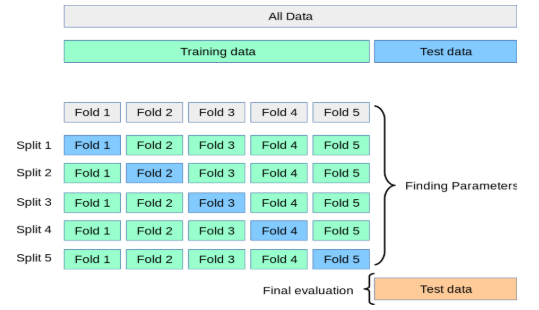

In [6]:
from IPython.display import Image
Image("KV splits.PNG")

For implementation, the simplest way to use cross-validation is to call the cross_val_score() helper function on the estimator and the dataset. The following example demonstrates how to estimate the accuracy of a linear kernel support vector machine on the 'iris' dataset by splitting the data, fitting a model and computing the score 5 consecutive times (with different splits each time):

In [7]:
clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, iris.data, iris.target, cv=5)
print(scores) 

scores2 = cross_val_score(clf, iris.data, iris.target, scoring='accuracy',cv=5)
print(scores2) # same as before

[0.96666667 1.         0.96666667 0.96666667 1.        ]
[0.96666667 1.         0.96666667 0.96666667 1.        ]


The mean score and the 95% confidence interval of the score estimate are hence given by:

In [8]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.98 (+/- 0.03)


This default score is based on **accuracy**, which is defined as accuracy=(TP+TN)/(TP+TN+FP+FN). Here, a **true positive** (TP) is an outcome where the model correctly predicts the positive class. Similarly, a **true negative** (TN) is an outcome where the model correctly predicts the negative class. A **false positive** (FP) is an outcome where the model incorrectly predicts the positive class. And a **false negative** (FN) is an outcome where the model incorrectly predicts the negative class. Here is an example of hand-calculating the accuracy metric:

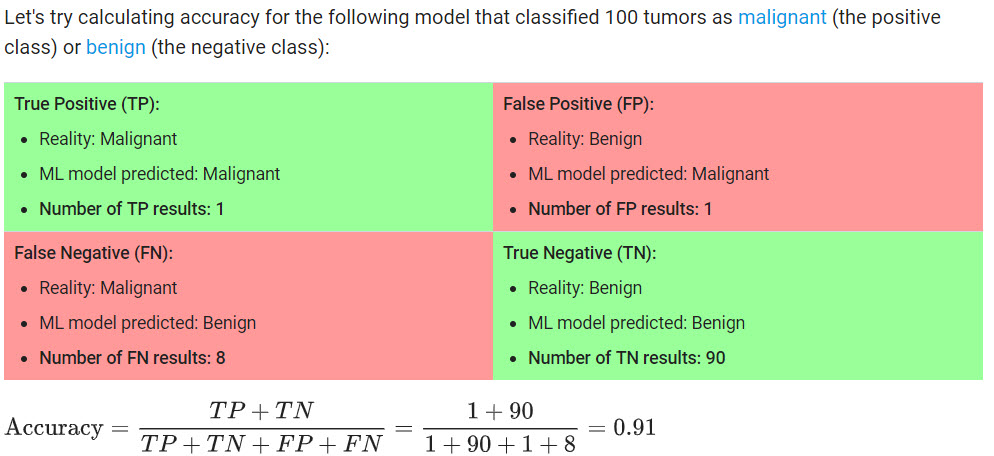

In [9]:
from IPython.display import Image
Image("accuracy example.jpg")

Keep in mind that accuracy alone doesn't tell the full story when you're working with a class-imbalanced data set, like this one, where there is a significant disparity between the number of positive and negative labels. Of the 100 tumor examples, 91 are benign (90 TNs and 1 FP) and 9 are malignant (1 TP and 8 FNs). Of the 91 benign tumors, the model correctly identifies 90 as benign. That's good. However, of the 9 malignant tumors, the model only correctly identifies 1 as malignant—a terrible outcome, as 8 out of 9 malignancies go undiagnosed! While 91% accuracy may seem good at first glance, another tumor-classifier model that always predicts benign would achieve the exact same accuracy (91/100 correct predictions) on our examples. In other words, our model is no better than one that has zero predictive ability to distinguish malignant tumors from benign tumors.

To solve the problem above, we introduce another set of concepts called precision and recall. Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. **Precision** attempts to answer the following question: what proportion of positive identifications was actually correct? Precision is rigorously defined as precision=TP/(TP+FP). **Recall** (also known as **true positive rate**) attempts to answer the following question: what proportion of actual positives was identified correctly? Mathematically, it is defined as recall=TP/(TP+FN). To fully evaluate the effectiveness of a model, you must examine both precision and recall. Unfortunately, precision and recall are often in tension. That is, improving precision typically reduces recall and vice versa. But in general, we want them to be close to 1 as much as we can. 

In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned. The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

Intuitively speaking, a system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

Note that the precision may not always decrease with recall. The definition of precision shows that lowering the threshold of a classifier may increase the denominator, by increasing the number of results returned. If the threshold was previously set too high, the new results may all be true positives, which will increase precision. If the previous threshold was about right or too low, further lowering the threshold will introduce false positives, decreasing precision. Meanwhile, the definition of recall does not depend on the classifier threshold. This means that lowering the classifier threshold may increase recall, by increasing the number of true positive results. It is also possible that lowering the threshold may leave recall unchanged, while the precision fluctuates. The relationship between recall and precision can be observed in the stairstep area of the plot - at the edges of these steps a small change in the threshold considerably reduces precision, with only a minor gain in recall.

Precision-recall curves are typically used in binary classification to study the output of a classifier. In order to extend the precision-recall curve to multi-class or multi-label classification, it is necessary to binarize the output. One curve can be drawn per label, but one can also draw a precision-recall curve by considering each element of the label indicator matrix as a binary prediction (micro-averaging).

Let's now see an example below:

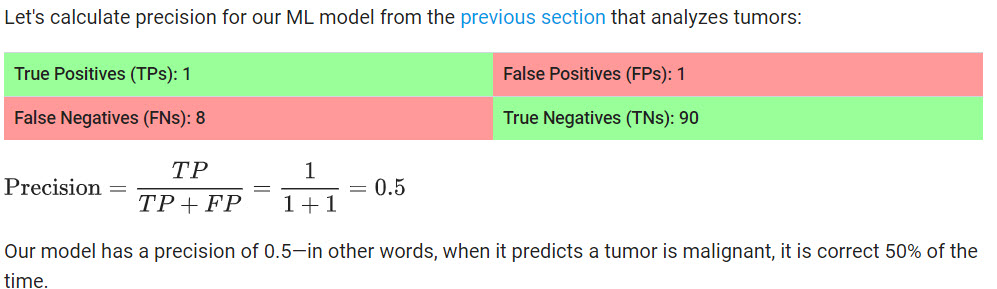

In [10]:
from IPython.display import Image
Image("precision example.jpg")

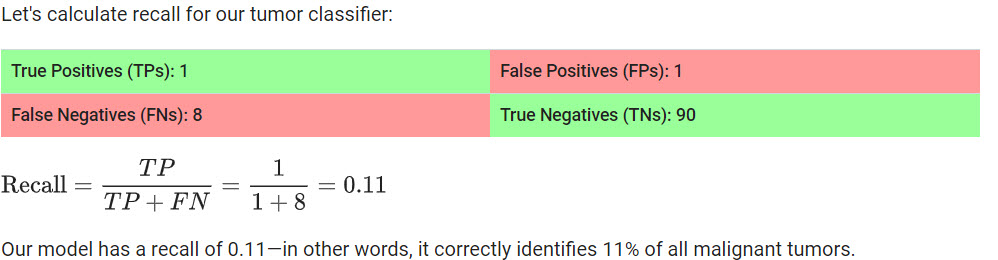

In [11]:
from IPython.display import Image
Image("recall example.jpg")

In comparison with the precision recall curve, the ROC-AUC curve is also another common metrics employed by data scientists. An **ROC curve** (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters: true positive rate (TPR) (or recall) and false positive rate(FPR) where TPR=TP/(TP+FN) and FPR=FP/(FP+TN). An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both FPs and TPs. The **AUC** (area under the curve) provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example. AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

AUC is desirable for the following two reasons:
   1. AUC is scale-invariant. It measures how well predictions are ranked, rather than their absolute values.
   2. AUC is classification-threshold-invariant. It measures the quality of the model's predictions irrespective of what classification threshold is chosen. However, both these reasons come with caveats, which may limit the usefulness of AUC in certain use cases: first, scale invariance is not always desirable. For example, sometimes we really do need well-calibrated probability outputs, and AUC won’t tell us about that. Second, classification-threshold invariance is not always desirable. In cases where there are wide disparities in the cost of false negatives vs. false positives, it may be critical to minimize one type of classification error. For example, when doing email spam detection, you likely want to prioritize minimizing false positives (even if that results in a significant increase of false negatives). AUC isn't a useful metric for this type of optimization.
   
Below is an example. 

In [12]:
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
print('AUC: ', roc_auc_score(y_true, y_scores))

AUC:  0.75


We now introduce another common metric. The **F1 score** can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is: F1 = 2(precision.recall)/(precision + recall). The F1 score is also called **Sorensen-Dice coefficient** or **Dice similarity coefficient (DSC)**. 

Going back to the original topic, model selection and evaluation using tools, such as model_selection.GridSearchCV() and model_selection.cross_val_score(), take a scoring parameter that controls what metric they apply to the estimators evaluated. For the most common use cases, one can designate a 'scorer' type of object with the scoring parameter; the table below shows all possible values. All 'scorer' objects follow the convention that higher return values are better than lower return values. Thus metrics which measure the distance between the model and the data, like metrics.mean_squared_error, are available as neg_mean_squared_error which return the negated value of the metric.

The table below gives us the staple of this lecture. Our future discussions all revolve around this table:

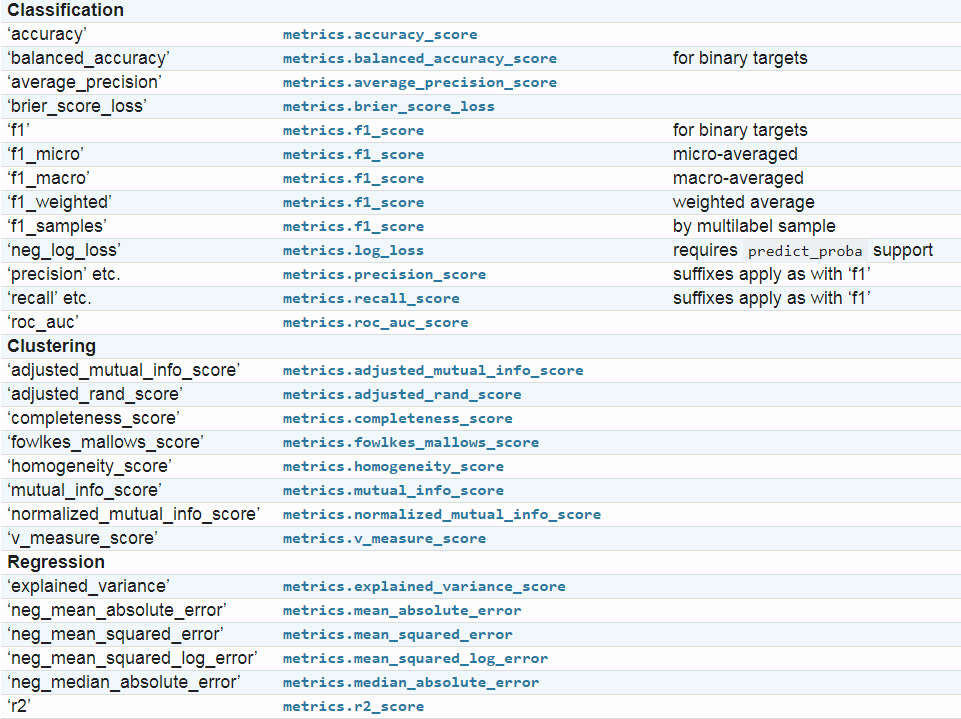

In [13]:
from IPython.display import Image
Image("validation scores list.jpg")

Now let's see an example by going back to the example of the SVM using the scoring method 'f1_macro' as an illusttive example:

In [14]:
scores3 = cross_val_score(clf, iris.data, iris.target, cv=10, scoring='f1_macro') # 10-folds CV, thus expecting 10 numbers
print(scores3)

[1.         0.93265993 1.         1.         0.86111111 1.
 0.93265993 1.         1.         1.        ]


In general, there are many metrics one can use flexibly when it comes to model evaluation. A lot of them can be creative and needs to be built by the user but a lot of them are also promptly available. The module 'sklearn.metrics' exposes a set of simple functions measuring a prediction error given ground truth and prediction: functions ending with 'score' return a value to maximize (the higher the better), whereas functions ending with 'error' or 'loss' return a value to minimize (the lower the better). The table above gave us a list of the 'big names' in model evaluation metrics. However, one can certainly make customized metrics based on their own need. The way to achieve it is to use the make_scorer() method. This method makes a scorer from a performance metric or loss function. This factory function wraps scoring functions for use in GridSearchCV() and cross_val_score(). It takes a score function (say accuracy) and returns a callable that scores an estimator’s output.

Here is an example. We already know that many metrics are not given names to be used as scoring values, sometimes because they require additional parameters, such as fbeta_score. In such cases, you need to generate an appropriate scoring object. The simplest way to generate a callable object for scoring is by using make_scorer(). That function converts metrics into callables that can be used for model evaluation. Below, we create a customized function for model evaluation. The custom_metric() function uses the make_scorer() method to let the customized loss function be passed onto the object. 

In [15]:
def my_custom_loss_func(y_true, y_pred):
    diff = np.abs(y_true - y_pred).max()
    return np.log1p(diff) # this calculates log(1+x)
custom_metric = make_scorer(my_custom_loss_func, greater_is_better=False)
clf = svm.SVC(kernel='linear', C=1)
scores4 = cross_val_score(clf, iris.data, iris.target, cv=5, scoring=custom_metric)
print(scores4) 

[-0.69314718 -0.         -0.69314718 -0.69314718 -0.        ]


In comparison to the the cross_val_score() function, the function cross_val_predict() has a similar interface to cross_val_score(), but returns, for each element in the input, the prediction that was obtained for that element when it was in the test set. Only cross-validation strategies that assign all elements to a test set exactly once can be used (otherwise, an exception is raised). The function cross_val_predict() is appropriate for: 1) visualization of predictions obtained from different models, and 2) model blending: when predictions of one supervised estimator are used to train another estimator in ensemble methods. Below is an example:

506 506


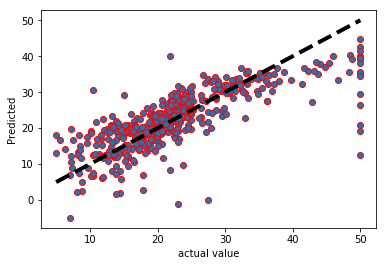

In [16]:
lr = linear_model.LinearRegression()
boston = datasets.load_boston()
y = boston.target # all the actual resopnse variables
predicted_cv = cross_val_predict(lr, boston.data, y, cv=10) # returns an array of the same size as 'y' where each entry is a prediction obtained by CV
print(len(y), len(predicted_cv))

fig, ax = plt.subplots()
ax.scatter(y, predicted_cv, edgecolors=(1, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('actual value')
ax.set_ylabel('Predicted')
plt.show()

When it comes to cross validation, another important function is cross_validate(). This function differs from cros_val_score() in two ways: 1) it allows specifying multiple metris for evaluation, and 2) it returns a dictionary object containing fit-times, score-times (and optionally training scores as well as fitted estimators) in addition to the test score. For single metric evaluation, where the scoring parameter is a string, callable or None, the keys will be ['test_score', 'fit_time', 'score_time']. For multiple metric evaluation, the return value is a dictionary object with the following keys - ['test_scorer1_name', 'test_scorer2_name', 'test_scorer...', 'fit_time', 'score_time']. The argument 'return_train_score' of cross_validate() is set to 'True' by default. It adds train score keys for all the scorers. If train scores are not needed, this should be set to 'False' explicitly. In addition, you may also retain the estimator fitted on each training set by setting the argument 'return_estimator=True'.

Here are some examples of how to use cross_validate(). First, the multiple metrics can be specified either as a list, tuple or set of predefined 'scorer' names:

In [17]:
vec1 = ['precision_macro', 'recall_macro']
clf = svm.SVC(kernel='linear', C=1, random_state=0)
scores5 = cross_validate(clf, iris.data, iris.target, scoring=vec1, cv=5, return_train_score=False)
print(sorted(scores5.keys()))
print(scores5['test_recall_macro'])                      

['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']
[0.96666667 1.         0.96666667 0.96666667 1.        ]


Or as a 'dict' mapping 'scorer'name to a predefined or custom scoring function:

In [18]:
vec2 = {'prec_macro': 'precision_macro', 'rec_micro': make_scorer(recall_score, average='macro')}
scores6 = cross_validate(clf, iris.data, iris.target, scoring=vec2, cv=5, return_train_score=True)
print(sorted(scores6.keys()))          
print(scores6['train_rec_micro'])

['fit_time', 'score_time', 'test_prec_macro', 'test_rec_micro', 'train_prec_macro', 'train_rec_micro']
[0.975      0.975      0.99166667 0.98333333 0.98333333]


We now do a deep dive into the famous metrics. We start our discussion with metrics used in classification settings. Let's first start from metrics.accuracy_score(). This function simply calculates the classification accuracy. In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in the true value. The function has an important argument 'normalize'. If set 'False', it returns the number of correctly classified samples. Otherwise, it returns the fraction of correctly classified samples. In binary and multiclass classification, this function is equal to the jaccard_similarity_score() function. Below is an example. Notice that the y_pred and p_true must be labels (because of the nature of the classification task), so elements of these vectors cannot be floats:

In [19]:
y_pred = [0, 2, 5, 3, 4]
y_true = [0, 1, 2, 3, 4]
print(accuracy_score(y_true, y_pred)) # default setting is normalize=True
print(accuracy_score(y_true, y_pred, normalize=False))

y_pred = ['A', 'B', 'C', 'D']
y_true = ['A', 'C', 'D', 'E']
print(accuracy_score(y_true, y_pred)) # default setting is normalize=True
print(accuracy_score(y_true, y_pred, normalize=False))

0.6
3
0.25
1


A similar metric (method) is metrics.balanced_accuracy_score(), which is defined as the average of recall obtained on each class. The best value is 1 and the worst value is 0 when the argument adjusted is set to be 'False'.

The next important metric is average precision given by metrics.average_precision_score(), which compute average precision (AP) from prediction scores. AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight: 

$$AP=\sum_{N=1}(R_N-R_{N-1})P_N$$

Here, $P_N$ and $R_N$ are precision and recall at the N-th threshold. This implementation is not interpolated and is different from computing the area under the precision-recall curve with the trapezoidal rule, which uses linear interpolation and can be too optimistic. Note also that this implementation is restricted to the binary classification task or multilabel classification task.

In [20]:
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8]) # target scores can either be probability estimates of the positive class, confidence values, or non-thresholded measure of decisions 
average_precision_score(y_true, y_scores)  

0.8333333333333333

Another common metric we use during classification tasks is the Brier score manifested in brier_score_loss(). The smaller the score, the better. Across all items in a set of predictions, the Brier score measures the mean squared difference between (1) the predicted probability assigned to the possible outcomes for a specific item, and (2) the actual outcome. Therefore, the lower the Brier score is for a set of predictions, the better the predictions are calibrated. Note that the Brier score always takes on a value between zero and one, since this is the largest possible difference between a predicted probability (which must be between zero and one) and the actual outcome (which can take on values of only 0 and 1). The Brier loss is composed of refinement loss and calibration loss. The Brier score is appropriate for binary and categorical outcomes that can be structured as true or false, but is inappropriate for ordinal variables which can take on three or more values (this is because the Brier score assumes that all possible outcomes are equivalently “distant” from one another). Which label is considered to be the positive label is controlled via the parameter pos_label, which defaults to 1.

In [21]:
y_true = np.array([0, 1, 1, 0])
y_true_categorical = np.array(["spam", "ham", "ham", "spam"])
y_prob = np.array([0.1, 0.9, 0.8, 0.3]) # probabilities of positive class
print(brier_score_loss(y_true=y_true, y_prob=y_prob, pos_label=1)) # if pos_label=None then the maximum label is used as positive class  
print(brier_score_loss(y_true, 1-y_prob, pos_label=0)) 
print(brier_score_loss(y_true_categorical, y_prob, pos_label="ham"))

0.03749999999999999
0.0375
0.03749999999999999


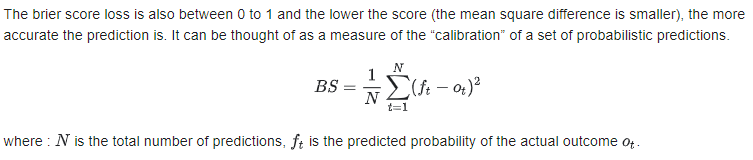

In [22]:
from IPython.display import Image
Image("brierscore.PNG")

We have highlighted a few important metrics used in classification settings, and now let's shift gears to the regression settings. Among these metrics, the most famous ones are mean squared errors and mean absolute errors. Here are some examples we have seen before:

In [23]:
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
print('MSE: ', mean_squared_error(y_true, y_pred))
print('MAE: ', mean_absolute_error(y_true, y_pred))

MSE:  0.375
MAE:  0.5


References:
   - http://scikit-learn.org/stable/modules/cross_validation.html
   - http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
   - https://developers.google.com/machine-learning/crash-course/classification/accuracy
   - https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall
   - https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
   - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer
   - https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py